# Train Siamese

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

Found 54 files for 27 unique classes


0epoch [00:00, ?epoch/s]

Epoch 1/150


2022-09-10 08:13:07.660016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 0.9895
Epoch 2/150
1/1 [==============================] - 0s 353ms/step - loss: 0.9872
Epoch 3/150
1/1 [==============================] - 0s 327ms/step - loss: 0.9848
Epoch 4/150
1/1 [==============================] - 0s 321ms/step - loss: 0.9650
Epoch 5/150
1/1 [==============================] - 0s 332ms/step - loss: 0.9554
Epoch 6/150
1/1 [==============================] - 0s 322ms/step - loss: 0.9419
Epoch 7/150
1/1 [==============================] - 0s 321ms/step - loss: 0.9258
Epoch 8/150
1/1 [==============================] - 0s 325ms/step - loss: 0.8780
Epoch 9/150
1/1 [==============================] - 0s 325ms/step - loss: 0.8530
Epoch 10/150
1/1 [==============================] - 0s 326ms/step - loss: 0.8216
Epoch 11/150
1/1 [==============================] - 0s 340ms/step - loss: 0.7980
Epoch 12/150
1/1 [==============================] - 0s 334ms/step - loss: 0.7520
Epoch 13/150
1/1 [==============================] - 

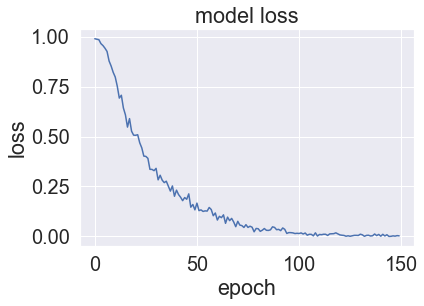


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 6575.67it/s]

100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1434.57it/s]


1/1 [==============================] - 1s 511ms/step


2022-09-10 08:13:46.777241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [5]:
# train_siamese.py

from datetime import datetime
import numpy
import tensorflow as tf
import tensorflow_addons as tfa
from absl import app
from tqdm.keras import TqdmCallback

from data.data_generator import DataGenerator
from model.siamese.config import cfg
from model.siamese.model_generator import create_model, base_models
import io
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow_datasets as tfds

TRAINABLE = True

base_model = list(base_models.keys())[0]  # MobileNetV2, ResNet101V2, EfficientNetB5

WEIGHTS_DIR = "model/siamese/weights"
datatype = 'train'

#def main(_argv):

model = create_model(trainable=TRAINABLE, base_model=base_model)
#prefix = "block3c_add" # DLiske there is a default configured so I commented this out
prefix = '' #DLiske it's used in the filename so i had to keep it

try:
    tf.keras.utils.plot_model(
        model,
        to_file=f"assets/{base_model}_model_fig.png",
        show_shapes=True,
        expand_nested=True,
    )
except ImportError as e:
    print(f"Failed to plot keras model: {e}")

ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path="data/filter_aug/train_old_2",
    exclude_aug=True,
    #step_size=4,
    step_size=1
)

# train_ds = ds_generator.get_dataset()

learning_rate = cfg.TRAIN.LEARNING_RATE

# optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) #DLiske the orig code had lr instead of learning_rate
loss_fun = tfa.losses.TripletSemiHardLoss() # DLiske comment only: The triplets are generated by TF
model.compile(loss=loss_fun, optimizer=optimizer, metrics=[])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    WEIGHTS_DIR + "/" + base_model + "/siam-{epoch}-"+str(learning_rate)+"-"+str(prefix)+"_{loss:.4f}.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)
stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=cfg.TRAIN.PATIENCE, mode="min", restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.6, patience=5, min_lr=1e-6, verbose=1,
#                                                  mode="min")

# Define the Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(
    ds_generator,
    epochs=cfg.TRAIN.EPOCHS,
    callbacks=[tensorboard_callback, checkpoint, TqdmCallback(verbose=0), stop],
    verbose=1
)

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

dataset = ds_generator.get_dataset()
results = model.predict(dataset)

# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
#out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
for img, labels in tfds.as_numpy(dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

# merge all embeddings per class
per_class = {}
idx = 0
for img, labels in tfds.as_numpy(dataset):
    for class_id in labels:
        if class_id not in per_class:
            per_class[class_id] = []
        per_class[class_id].append(results[idx])
        idx += 1

mean_values = None
labels = None
# calculate average value for each class
for class_id, values in per_class.items():
    #print("CLASS_ID", class_id)#, values)
    matrix = np.array(values)
    mean_val = np.mean(matrix, axis=0)
    if mean_values is None:
        mean_values = np.array([mean_val])
    else:
        mean_values = np.concatenate((mean_values, np.array([mean_val])), axis=0)
    if labels is None:
        labels = np.array([class_id], dtype='U20')
    else:
        labels = np.concatenate((labels, [class_id]), axis=0, dtype='U20')

        
        
datatype = 'train'
# DLiske (I added b/c it seems like we shouldn't overwrite the avg embeddings if we're doing this on Test...)
if datatype == 'train': # DLiske
    # save avg embedding per class to be used as visualization and for further processing
    np.savetxt(f"vecs-conc-{base_model}.tsv", mean_values, delimiter="\t")
    #np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%i", delimiter="\t")
    np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%s", delimiter="\t") #D LISKE
    # np.savetxt(
    #     f"emb_space.csv", np.concatenate((mean_values, labels), axis=1), delimiter="\t"
    # )



# Generate Siamese Embedded Space

In [9]:
labels

array(['Chinnar 4 Female', 'Chinnar 10 Male', 'TVM 2 Male',
       'Chinnar 5 Male', 'Chinnar 17 Male', 'Chinnar 7 Juvenile',
       'TVM 10 Male', 'Chinnar 3 Female', 'TVM 7 Female',
       'Chinnar 15 Female', 'Chinnar 16 Male', 'TVM 8 Female',
       'Chinnar 13 Female', 'TVM 4 Female', 'Chinnar 12 Juvenile',
       'Chinnar 9 Female', 'Chinnar 14 Female', 'TVM 3 Female',
       'TVM 9 Male', 'Chinnar 2 Male', 'TVM 5 Male', 'Chinnar  6 Male',
       'Chinnar 11 Male', 'Chinnar 1 Male', 'TVM 1 Male',
       'Chinnar 8 Male', 'TVM 6 Female'], dtype='<U20')

In [16]:
# generate_siamese_emb_space.py

import io
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
from absl import app, flags
from absl.flags import FLAGS

from data.data_generator import DataGenerator
from model.siamese.model_generator import create_model, base_models
from model.siamese.config import cfg

# flags.DEFINE_string(
#     "weights",
#     "siam-118-0.0001-1.0a_0.0633.h5",
#     "weights name",
# )

# flags.DEFINE_string(
#     "datatype",
#     "train",
#     "weights name",
# )
datatype = 'train' #D LISKE
weights = 'siam-121-0.0001-_0.0000.h5' #D LISKE

WEIGHTS_DIR = "model/siamese/weights"

base_model = list(base_models.keys())[0]  # MobileNetV2, ResNet101V2, EfficientNetB5


### def main(_argv):
#model = create_model(base_model=base_model)
# if FLAGS.datatype != "train" and FLAGS.datatype != "test":
#     FLAGS.datatype = "train"

if datatype != "train" and datatype != "test":
    datatype = "train"


#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")


ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    #folder_path=f"data/filter_aug/{FLAGS.datatype}",
    #folder_path=f"data/filter_aug/{datatype}",
    folder_path=f"data/filter_aug/train",
    exclude_aug=True,
    step_size=1,
)

dataset = ds_generator.get_dataset()

results = model.predict(dataset)

# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
#out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
for img, labels in tfds.as_numpy(dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

# merge all embeddings per class
per_class = {}
idx = 0
for img, labels in tfds.as_numpy(dataset):
    for class_id in labels:
        if class_id not in per_class:
            per_class[class_id] = []
        per_class[class_id].append(results[idx])
        idx += 1

mean_values = None
labels = None
# calculate average value for each class
for class_id, values in per_class.items():
    #print("CLASS_ID", class_id)#, values)
    matrix = np.array(values)
    mean_val = np.mean(matrix, axis=0)
    if mean_values is None:
        mean_values = np.array([mean_val])
    else:
        mean_values = np.concatenate((mean_values, np.array([mean_val])), axis=0)
    if labels is None:
        labels = np.array([class_id], dtype='U20')
    else:
        labels = np.concatenate((labels, [class_id]), axis=0, dtype='U20')
              
# DLiske (I added b/c it seems like we shouldn't overwrite the avg embeddings if we're doing this on Test...)
if datatype == 'train': # DLiske
    # save avg embedding per class to be used as visualization and for further processing
    np.savetxt(f"vecs-conc-{base_model}.tsv", mean_values, delimiter="\t")
    #np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%i", delimiter="\t")
    np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%s", delimiter="\t") #D LISKE
    # np.savetxt(
    #     f"emb_space.csv", np.concatenate((mean_values, labels), axis=1), delimiter="\t"
    # )



Found 36 files for 18 unique classes


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1043.55it/s]
2022-09-10 07:44:51.531159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 741ms/step


# Test Siamese

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 54 files for 27 unique classes



 94%|████████████████████████████████████████▌  | 51/54 [00:01<00:00, 32.39it/s]/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

,precision,recall,f1-score,support
Chinnar 6 Male,1.00,1.00,1.00,2.00
Chinnar 1 Male,1.00,1.00,1.00,2.00
Chinnar 10 Male,0.00,0.00,0.00,2.00
Chinnar 11 Male,0.00,0.00,0.00,2.00
Chinnar 12 Juvenile,0.00,0.00,0.00,2.00
Chinnar 13 Female,1.00,1.00,1.00,2.00
Chinnar 14 Female,0.50,1.00,0.67,2.00
Chinnar 15 Female,0.50,1.00,0.67,2.00
Chinnar 16 Male,1.00,1.00,1.00,2.00
Chinnar 17 Male,0.00,0.00,0.00,2.00


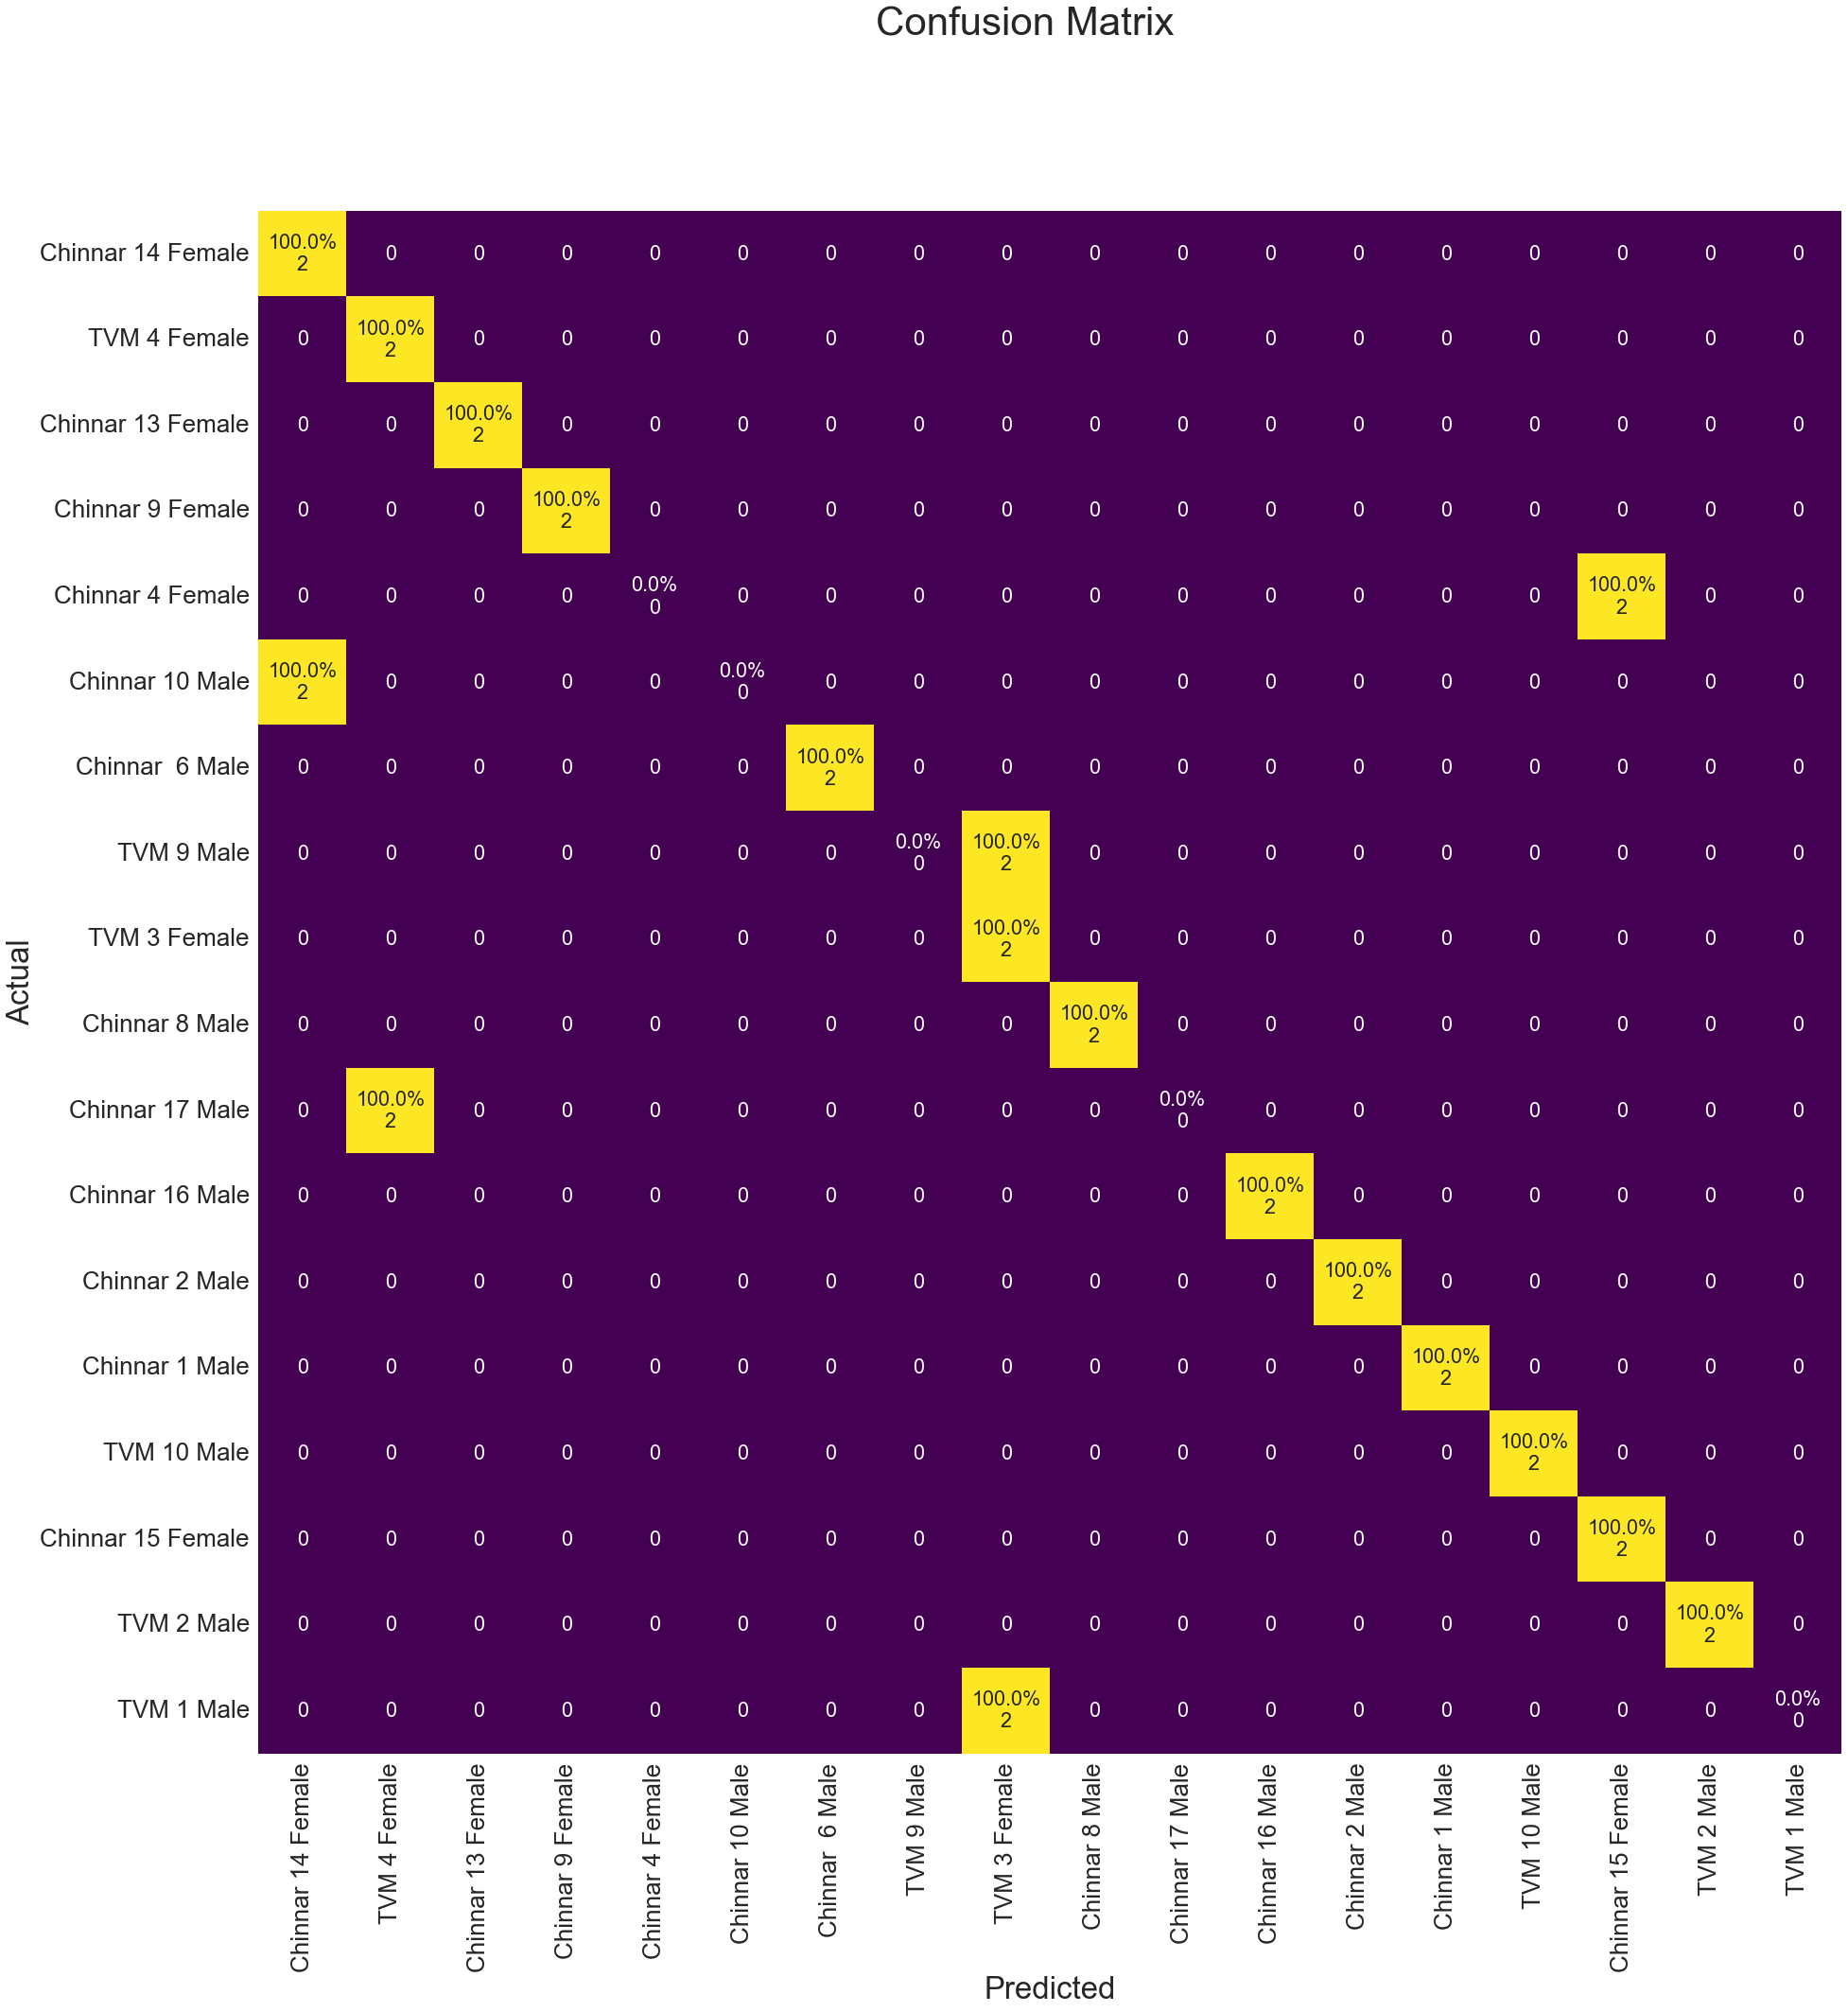

In [7]:
# test_siamese.py

%load_ext autoreload
%autoreload 2

import time

import numpy as np
import os
import datetime
from absl import app, flags
from absl.flags import FLAGS

from data.data_generator import DataGenerator
#from data.names import names
from helpers.score_processing import cm_analysis, classification_report_latex
from model.siamese.model_generator import create_model, base_models
from model.siamese.config import cfg
from data.siamese_evaluator import SiameseEvaluator

names = pd.read_csv('/Users/debbieliske/Documents/CodingProjects/farm-animal-tracking-main/names.csv')
# flags.DEFINE_string(
#     "weights",
#     "siam-147-0.001-block3c_add_0.2488.h5",
#     "weights name",
# )

# flags.DEFINE_string(
#     "datatype",
#     "train",
#     "weights name",
# )

# flags.DEFINE_string(
#     "vectors",
#     "model/siamese/vectors/vecs-conc-EfficientNetB5.tsv",
#     "path to vectors tsv",
# )

# flags.DEFINE_string(
#     "meta",
#     "model/siamese/vectors/meta-conc-EfficientNetB5.tsv",
#     "path to meta tsv",
# )

WEIGHTS_DIR = "model/siamese/weights"
weights = 'siam-121-0.0001-_0.0000.h5' # DLiske
vectors = 'vecs-conc-MobileNetV2.tsv' # DLiske
meta = 'meta-conc-MobileNetV2.tsv'  # DLiske

#base_model = list(base_models.keys())[0]
# flags.DEFINE_string('target', './crop_images/5.jpg', 'path to input image')
# flags.DEFINE_string('source', './crop_images/1.jpg', 'path to input image')


def generate_test_dir(basemodel):
    test_dir = os.path.join(
        "experiments", "siamese", basemodel
    )

    if not os.path.isdir(test_dir):
        os.mkdir(test_dir)

    out_dir = os.path.join(
        test_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    )

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    return out_dir


#def main(_argv):
out_dir = generate_test_dir(base_model)

#model = create_model(base_model=base_model)
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")
ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path=f"data/filter_aug/test_old_2",
    exclude_aug=True,
    step_size=1,
)

# images = ds_generator.__getitem__(1)
# print(images[0].shape)
# print(images[1])

names = labels

evaluator = SiameseEvaluator(model=model, dataset=ds_generator.org_images)
#evaluator.set_avg_vectors(FLAGS.vectors, FLAGS.meta)
evaluator.set_avg_vectors(vectors, meta)
conf_matrix, class_report = evaluator.run_evaluation(compare_type="individual")
display(pd.DataFrame(class_report).transpose().round(2))
cm_analysis(conf_matrix, names, filename=os.path.join(out_dir, f"conf_matrix_{base_model}.png"))
#classification_report_latex(class_report, filename=os.path.join(out_dir, f"class_report_{base_model}.txt"))

### DLiske: I added this b/c it seems we'd want to create embeddings for the test as well....?
# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
# datatype = 'test'
# np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
# #out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
# out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
# for img, labels in tfds.as_numpy(dataset):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()


In [11]:
labels

array(['Chinnar 14 Female', 'TVM 4 Female', 'Chinnar 13 Female',
       'Chinnar 9 Female', 'Chinnar 4 Female', 'Chinnar 10 Male',
       'Chinnar  6 Male', 'TVM 9 Male', 'TVM 3 Female', 'Chinnar 8 Male',
       'Chinnar 17 Male', 'Chinnar 16 Male', 'Chinnar 2 Male',
       'Chinnar 1 Male', 'TVM 10 Male', 'Chinnar 15 Female', 'TVM 2 Male',
       'TVM 1 Male'], dtype='<U20')